# Importing modules

In [1]:
import numpy as np
from sklearn.decomposition import PCA
import scipy.io as sio
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import os
import random
from random import shuffle
from skimage.transform import rotate
import scipy.ndimage

# Loading the Datasets

In [2]:
def loadPaviaUData():
    data_path = os.path.join('F:\main_project\Datasets')
    data = sio.loadmat(os.path.join(data_path, 'PaviaU.mat'))['paviaU']
    labels = sio.loadmat(os.path.join(data_path, 'PaviaU_gt.mat'))['paviaU_gt']
    
    return data, labels

# Spliting the datasets

In [3]:
def splitTrainTestSet(X, y, testRatio=0.10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=345,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [4]:
def oversampleWeakClasses(X, y):
    uniqueLabels, labelCounts = np.unique(y, return_counts=True)
    maxCount = np.max(labelCounts)
    labelInverseRatios = maxCount / labelCounts  
    # repeat for every label and concat
    newX = X[y == uniqueLabels[0], :, :, :].repeat(round(labelInverseRatios[0]), axis=0)
    newY = y[y == uniqueLabels[0]].repeat(round(labelInverseRatios[0]), axis=0)
    for label, labelInverseRatio in zip(uniqueLabels[1:], labelInverseRatios[1:]):
        cX = X[y== label,:,:,:].repeat(round(labelInverseRatio), axis=0)
        cY = y[y == label].repeat(round(labelInverseRatio), axis=0)
        newX = np.concatenate((newX, cX))
        newY = np.concatenate((newY, cY))
    np.random.seed(seed=42)
    rand_perm = np.random.permutation(newY.shape[0])
    newX = newX[rand_perm, :, :, :]
    newY = newY[rand_perm]
    return newX, newY

In [5]:
def standartizeData(X):
    newX = np.reshape(X, (-1, X.shape[2]))
    scaler = preprocessing.StandardScaler().fit(newX)  
    newX = scaler.transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1],X.shape[2]))
    return newX, scaler

In [6]:
def applyPCA(X, numComponents=35):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

In [7]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [8]:
def createPatches(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [9]:
def AugmentData(X_train):
    for i in range(int(X_train.shape[0]/2)):
        patch = X_train[i,:,:,:]
        num = random.randint(0,2)
        if (num == 0):
            
            flipped_patch = np.flipud(patch)
        if (num == 1):
            
            flipped_patch = np.fliplr(patch)
        if (num == 2):
            
            no = random.randrange(-180,180,30)
            flipped_patch = scipy.ndimage.interpolation.rotate(patch, no,axes=(1, 0),
                                                               reshape=False, output=None, order=3, mode='constant', cval=0.0, prefilter=False)
    
    
    patch2 = flipped_patch
    X_train[i,:,:,:] = patch2
    
    return X_train


In [10]:
def savePreprocessedData(X_trainPatches, X_testPatches, y_trainPatches, y_testPatches, windowSize, wasPCAapplied = False, numPCAComponents = 0, testRatio = 0.25):
    if wasPCAapplied:
        with open("X_trainPatches_" + str(windowSize) + "PCA" + str(numPCAComponents) + "testRatio" + str(testRatio) + ".npy", 'bw') as outfile:
            np.save(outfile, X_trainPatches)
        with open("X_testPatches_" + str(windowSize) + "PCA" + str(numPCAComponents) + "testRatio" + str(testRatio) + ".npy", 'bw') as outfile:
            np.save(outfile, X_testPatches)
        with open("y_trainPatches_" + str(windowSize) + "PCA" + str(numPCAComponents) + "testRatio" + str(testRatio) + ".npy", 'bw') as outfile:
            np.save(outfile, y_trainPatches)
        with open("y_testPatches_" + str(windowSize) + "PCA" + str(numPCAComponents) + "testRatio" + str(testRatio) + ".npy", 'bw') as outfile:
            np.save(outfile, y_testPatches)
    else:
        with open("../preprocessedData/XtrainWindowSize" + str(windowSize) + ".npy", 'bw') as outfile:
            np.save(outfile, X_trainPatches)
        with open("../preprocessedData/XtestWindowSize" + str(windowSize) + ".npy", 'bw') as outfile:
            np.save(outfile, X_testPatches)
        with open("../preprocessedData/ytrainWindowSize" + str(windowSize) + ".npy", 'bw') as outfile:
            np.save(outfile, y_trainPatches)
        with open("../preprocessedData/ytestWindowSize" + str(windowSize) + ".npy", 'bw') as outfile:
            np.save(outfile, y_testPatches)

In [11]:
myFile = open('global_variables.txt', 'r') 
file = myFile.readlines()[:]


for line in file:

    if line[0:3] == "win":

        ds = line.find('=')
        windowSize = int(line[ds+1:-1],10)

    elif line[0:3] == "num":

        ds = line.find('=')
        numPCAcomponents = int(line[ds+2:-1],10)

    else:

        ds = line.find('=')
        testRatio = float(line[ds+1:])

In [12]:
Dataset, GroundTruth= loadPaviaUData()

In [13]:
Dataset,pca = applyPCA(Dataset,numPCAcomponents)

In [14]:
XPatches, yPatches = createPatches(Dataset, GroundTruth, windowSize=windowSize)

In [15]:
X_train, X_test, y_train, y_test = splitTrainTestSet(XPatches, yPatches, testRatio)

In [16]:
X_train, y_train = oversampleWeakClasses(X_train, y_train)

In [17]:
X_train = AugmentData(X_train)

In [18]:
savePreprocessedData(X_train, X_test, y_train, y_test, windowSize = windowSize,wasPCAapplied=True, numPCAComponents = numPCAcomponents,testRatio = testRatio)

In [19]:
import numpy as np
import scipy
import os
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras import backend as K
K.common.set_image_dim_ordering('th')
from keras.utils import np_utils
#from sklearn.cross_validation import StratifiedKFold

Using TensorFlow backend.


In [20]:
X_train = np.load("X_trainPatches_" + str(windowSize) + "PCA" + str(numPCAcomponents) + "testRatio" + str(testRatio)  + ".npy")

y_train = np.load("y_trainPatches_" + str(windowSize) + "PCA" + str(numPCAcomponents) + "testRatio" + str(testRatio) + ".npy")

In [21]:
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[3], X_train.shape[1], X_train.shape[2]))

In [22]:
# convert class labels to on-hot encoding
y_train = np_utils.to_categorical(y_train)

In [23]:
input_shape= X_train[0].shape
print(input_shape)

(30, 5, 5)


In [24]:
# number of filters
C1 = 3*numPCAcomponents

In [25]:
# Define the model
model = Sequential()

model.add(Conv2D(C1, (3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(3*C1, (3, 3), activation='relu'))
model.add(Dropout(0.25))



model.add(Flatten())
model.add(Dense(6*numPCAcomponents, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(9, activation='softmax'))

In [26]:
sgd = SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [27]:
model.fit(X_train, y_train, batch_size=32, epochs=5)

Epoch 1/5
128051/128051 [==============================] - 202s 2ms/step - loss: 0.9935 - accuracy: 0.6807
Epoch 2/5
128051/128051 [==============================] - 204s 2ms/step - loss: 0.3036 - accuracy: 0.8966
Epoch 3/5
128051/128051 [==============================] - 199s 2ms/step - loss: 0.2063 - accuracy: 0.9300
Epoch 4/5
128051/128051 [==============================] - 200s 2ms/step - loss: 0.1646 - accuracy: 0.9445
Epoch 5/5
128051/128051 [==============================] - 196s 2ms/step - loss: 0.1370 - accuracy: 0.9532


In [28]:
import h5py
from keras.models import load_model

In [29]:
model.save('my_model' + str(windowSize) + 'PCA' + str(numPCAcomponents) + "testRatio" + str(testRatio) + '.h5')

In [30]:
# Import the necessary libraries
from keras.models import load_model
from keras.utils import np_utils
from sklearn.metrics import classification_report, confusion_matrix,cohen_kappa_score
import itertools
import spectral
import matplotlib
%matplotlib inline

In [31]:

def reports (X_test,y_test):
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    target_names = ['Asphalt','Meadows','Gravel','Trees','Painted metal sheets','Bare Soil','Bitumen','Sels-Blocking Bricks','Shadows']

    
    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    avgAcc=[]
    classArray=[]
    for c in range(len(confusion)):
        recallSoc=confusion[c][c]/sum(confusion[c])
        classArray+=[recallSoc]
    avgAcc.append(sum(classArray)/len(classArray))
    avg_accuracy=np.mean(avgAcc)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    overall_loss, overall_accu = model.evaluate(X_test, y_test, verbose=False)
    
    
    return classification, confusion,kappa,avg_accuracy,overall_accu


In [32]:
def Patch(data,height_index,width_index):
    #transpose_array = data.transpose((2,0,1))
    #print transpose_array.shape
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    return patch

In [33]:
X_test  = np.reshape(X_test, (X_test.shape[0], X_test.shape[3], X_test.shape[1], X_test.shape[2]))
y_test = np_utils.to_categorical(y_test)

In [34]:
# load the model architecture and weights
model = load_model('my_model' + str(windowSize) + 'PCA' + str(numPCAcomponents) + "testRatio" + str(testRatio) + '.h5')

In [35]:
# Using the pretrained model make predictions and print the results into a report
classification, confusion,  kappa, overall_accuracy, Average_accuracy = reports(X_test,y_test)
print('Classification_report:\n')
print('{}\n'.format(classification))
print('Confusion_matrix :\n')
print('{}\n'.format(confusion))
print('Kappa value : {}\n'.format(kappa))
print('Overall accuracy : {}\n'.format(overall_accuracy))
print('Average_accuracy : {}\n'.format(Average_accuracy))

Classification_report:

                      precision    recall  f1-score   support

             Asphalt       0.99      0.97      0.98      1658
             Meadows       0.99      0.97      0.98      4662
              Gravel       0.89      0.88      0.88       525
               Trees       0.98      0.99      0.99       766
Painted metal sheets       1.00      1.00      1.00       336
           Bare Soil       0.92      0.98      0.95      1257
             Bitumen       0.93      0.99      0.96       332
Sels-Blocking Bricks       0.90      0.93      0.91       921
             Shadows       0.99      1.00      1.00       237

            accuracy                           0.97     10694
           macro avg       0.96      0.97      0.96     10694
        weighted avg       0.97      0.97      0.97     10694


Confusion_matrix :

[[1603    0    6    0    0    3   23   23    0]
 [   2 4538    0   12    0  103    0    7    0]
 [   1    0  461    0    0    0    0   63    0]
 [

In [36]:
# load the original image
Dataset, GroundTruth = loadPaviaUData()

In [37]:
Dataset,pca = applyPCA(Dataset,numPCAcomponents)

In [39]:
height = GroundTruth.shape[0]
width = GroundTruth.shape[1]
PATCH_SIZE = windowSize
numPCAcomponents = numPCAcomponents

In [41]:
# calculate the predicted image
outputs = np.zeros((height,width))
for i in range(height-PATCH_SIZE+1):
    for j in range(width-PATCH_SIZE+1):
        target = GroundTruth[int(i+PATCH_SIZE/2), int(j+PATCH_SIZE/2)]
        if target == 0 :
            continue
        else :
            image_patch=Patch(Dataset,i,j)
            #print (image_patch.shape)
            X_test_image = image_patch.reshape(1,image_patch.shape[2],image_patch.shape[0],image_patch.shape[1]).astype('float32')                                   
            prediction = (model.predict_classes(X_test_image))                         
            outputs[int(i+PATCH_SIZE/2)][int(j+PATCH_SIZE/2)] = prediction+1

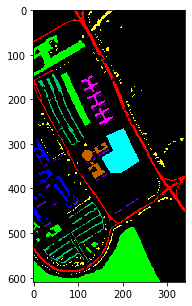

In [42]:
# Plot the Ground Truth Image
ground_truth = spectral.imshow(classes = GroundTruth,figsize =(5,5))
plt.title('Classification map of GroundTruth')
plt.colorbar()

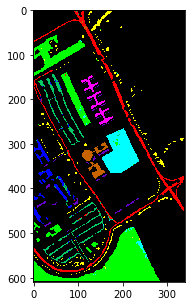

In [43]:
# Plot the Predicted image
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(5,5))
plt.title('Predicted Classification map by CNN')
plt.colorbar()

In [44]:
from tqdm import tqdm
import pandas as pd
def extract_pixels(dataset, ground_truth):
    df = pd.DataFrame()
    for i in tqdm(range(dataset.shape[2])):
        df = pd.concat([df, pd.DataFrame(dataset[:, :, i].ravel())], axis=1)
    df = pd.concat([df, pd.DataFrame(ground_truth.ravel())], axis=1)
    df.columns = [f'band-{i}' for i in range(1, 1+dataset.shape[2])]+['class']
    return df

In [45]:
df = extract_pixels(Dataset,GroundTruth)

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.85it/s]


In [46]:
df.to_csv('Dataset.csv', index=False)

In [47]:
df = pd.read_csv('Dataset.csv')

In [48]:
df.head()

,band-1,band-2,band-3,band-4,band-5,band-6,band-7,band-8,band-9,band-10,...,band-22,band-23,band-24,band-25,band-26,band-27,band-28,band-29,band-30,class
0,-0.920134,1.542995,0.992466,1.019944,-0.774048,-2.695414,1.140214,1.454452,-1.810544,1.905855,...,-0.612583,0.643593,0.894020,0.301778,0.860657,0.948755,-0.367806,-0.096344,-1.297209,0
1,-1.086655,0.717241,0.947675,0.384608,-1.307291,-1.605801,1.411176,0.978857,-1.824406,1.370275,...,0.092762,0.542794,0.056056,-0.360312,0.642724,-0.834398,-1.484430,-0.647981,0.824532,0
2,-1.288945,0.263153,0.907275,1.019979,0.113350,-1.814865,-0.544383,0.046225,-1.337938,0.107269,...,-0.292814,0.470057,0.104593,0.976036,0.171821,-0.028809,0.825754,-0.170735,-0.821857,0
3,-1.173133,0.771808,0.729298,1.235721,-0.900821,-1.325197,0.849179,-0.015451,-1.416055,1.432525,...,-1.278490,0.369815,-0.096958,-1.213936,1.003311,-0.320932,0.452404,-0.051617,-0.495302,0
4,-1.160750,0.489303,0.670962,0.067778,-0.580534,-0.611783,-0.276626,-0.511947,-0.801633,1.632529,...,0.303518,-0.148666,0.306018,0.692015,-1.876743,0.437166,-1.211834,-0.315729,0.260082,0


In [49]:
df.tail()

,band-1,band-2,band-3,band-4,band-5,band-6,band-7,band-8,band-9,band-10,...,band-22,band-23,band-24,band-25,band-26,band-27,band-28,band-29,band-30,class
207395,-0.770975,0.047431,-0.024353,-0.039267,0.347382,0.306568,-0.094786,-0.296737,-0.156745,-0.912093,...,0.348055,-0.441291,0.319767,0.677104,0.162559,0.854683,0.977026,-0.172818,0.715302,0
207396,-0.716873,0.155604,0.129100,0.138532,0.410377,0.317541,-0.081034,-1.595349,-0.440342,-1.706435,...,0.375864,0.416711,-0.273667,0.097429,-0.462823,1.764673,-0.546483,-0.337229,-0.854291,0
207397,-0.710181,0.373100,0.163947,-0.715615,0.341184,0.686904,-0.030147,-0.554701,0.509995,-0.441717,...,-0.104236,0.590469,-0.881546,-0.029832,-0.141225,-0.158649,0.115054,-0.283687,-1.335424,0
207398,-0.722259,0.279649,0.323812,-0.314122,-0.455909,0.932808,-0.129387,-1.077168,0.145284,-1.327086,...,1.282621,-0.256876,0.060861,0.060841,-0.361786,0.692921,-0.169507,-0.076699,-1.639181,0
207399,-0.730116,0.495178,0.294649,-0.110439,-0.520752,0.848315,-0.754808,0.484016,0.571128,-0.670774,...,-1.008317,0.880688,-0.030159,-0.287177,0.642240,-0.848415,0.752263,0.207435,0.603852,0


In [50]:
df.count()

band-1     207400
band-2     207400
band-3     207400
band-4     207400
band-5     207400
band-6     207400
band-7     207400
band-8     207400
band-9     207400
band-10    207400
band-11    207400
band-12    207400
band-13    207400
band-14    207400
band-15    207400
band-16    207400
band-17    207400
band-18    207400
band-19    207400
band-20    207400
band-21    207400
band-22    207400
band-23    207400
band-24    207400
band-25    207400
band-26    207400
band-27    207400
band-28    207400
band-29    207400
band-30    207400
class      207400
dtype: int64

In [51]:
Dataset = df.iloc[:, :-1].values

GroundTruth = df.iloc[:, -1].values

In [52]:
Dataset.shape, GroundTruth.shape

((207400, 30), (207400,))

In [55]:
from matplotlib import pyplot as plt

In [56]:
def plot_signature(df):
    plt.figure(figsize=(12, 6))
    pixel_no = np.random.randint(df.shape[0])
    plt.plot(range(1, 31), df.iloc[pixel_no, :-1].values.tolist(), 'b--', label= f'Class - {df.iloc[pixel_no, -1]}')
    plt.legend()
    plt.title(f'Pixel({pixel_no}) signature', fontsize=14)
    plt.xlabel('Band Number', fontsize=14)
    plt.ylabel('Pixel Intensity', fontsize=14)
    plt.show()

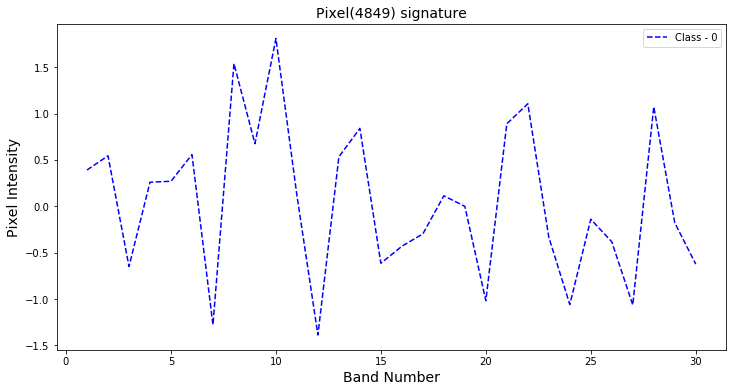

In [57]:
plot_signature(df)

In [58]:
print(f"Unique Class Labels: {df.loc[:, 'class'].unique()}")

Unique Class Labels: [0 1 4 2 8 5 9 6 3 7]


In [59]:
df.loc[:, 'class'].value_counts()

0    164624
2     18649
1      6631
6      5029
8      3682
4      3064
3      2099
5      1345
7      1330
9       947
Name: class, dtype: int64

In [60]:
df[df['class']== 5][0:2000]

,band-1,band-2,band-3,band-4,band-5,band-6,band-7,band-8,band-9,band-10,...,band-22,band-23,band-24,band-25,band-26,band-27,band-28,band-29,band-30,class
49432,5.473765,-0.333763,7.919475,-0.107699,5.150626,3.375921,-0.471460,2.163552,-2.589462,0.318156,...,-0.616124,1.409804,-1.359548,-0.158163,-0.120589,-1.172246,-0.809122,-0.994118,-1.891036,5
49769,5.338089,-0.257692,7.487268,-0.252586,5.022560,3.045689,-2.067593,1.745040,-3.653726,-0.558318,...,0.483332,0.638860,-0.599522,-0.402338,1.404153,0.515001,-1.569584,1.976447,2.441379,5
49770,5.523727,-0.333338,8.069374,0.616138,4.767682,3.223675,-2.128807,2.285339,-1.761922,0.722875,...,-0.923050,0.849008,0.325243,-1.355275,3.131137,-1.186038,-0.498540,-1.139750,-0.915302,5
49771,5.528564,-0.330620,8.043535,0.168584,5.481406,3.197497,-0.394679,1.530300,-1.525528,0.858789,...,-1.315183,1.344568,0.999535,2.612432,2.081715,-2.514774,-2.148045,-2.307433,-0.278768,5
49772,5.526334,-0.371601,8.053768,0.386579,4.805901,3.239905,-0.790677,2.611328,-1.280788,0.531532,...,-0.224098,0.310274,-0.779920,0.390289,1.121918,-3.336741,-1.118723,-0.628516,0.125785,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87191,1.547211,-1.176612,4.143351,-0.202254,2.288876,1.630643,-0.592496,0.946423,-1.733664,-0.374670,...,0.094297,0.233040,0.389494,2.018213,0.428843,-0.174410,0.881477,-0.409232,3.578169,5
87192,1.556239,-1.175417,4.115517,0.604624,2.156464,1.544553,0.416941,0.251525,-1.355066,0.130006,...,-0.660210,1.299281,-0.714019,-2.385442,1.241083,-0.236612,-2.027397,1.701378,-1.419370,5
87529,1.502997,-1.101673,3.666236,-1.093412,2.827503,1.304733,0.280854,1.789211,-0.835092,-0.522595,...,0.695892,0.267541,2.215237,0.309823,0.015853,-0.989863,0.080615,-0.218571,1.067654,5
87530,1.567793,-1.243340,4.333702,0.275167,2.028385,1.669621,-0.602604,0.989234,-0.145559,-0.118842,...,-0.885521,0.698764,-1.570846,-0.303836,-1.400238,0.311686,-2.163281,-0.672872,-0.558671,5
